**Import useful libraries**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
sys.path.append('/gpfs/exfel/exp/MID/202305/p003348/scratch/maddalena/MID-LTP-3348/scripts')
import numpy as np
from agipd_xpcs import get_saxs_xpcs
import extra_data as ex
import matplotlib.pyplot as plt
import pandas as pd

from xpcs_functions import average_xpcs 
from xpcs_analysis import plot_xpcs
from xpcs_analysis import fit_xpcs
from xpcs_functions import *
import xarray as xr
import matplotlib as mpl
# mpl.rcParams.update({'font.size': 20})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

### Useful functions

In [2]:
def add_colorbar_hor(ax, vec, label=None):
    """Nice colorbar for plots"""
    vec = np.array(vec)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=-0.1)

    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=vec.min(), vmax=vec.max())

    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label(label,fontsize=12,labelpad=5, y=0.5, rotation=90)
#     cb1.ax.set_title(label)

def exp_fun(x, beta, A, tau, kww): 
    """exponential function for fitting the g2 [contrast, baseline, time constant, kww exponent]"""
    return A + beta*np.exp( -2*(x/tau)**kww )

def linear(x, m, c):
    """linear function"""
    return m * x + c

def get_info_from_docs(run_number, docs):
    """Function to get the info about a given run
    Args: 
       run_number: int
       docs: elog of the experiment imported as a pandas dataframe
    """
    for i in docs:
        if isinstance(i[0], str):
            if len(i[0]) == 3:
                if int(i[0]) == run_number:
                    exp_name = i[2]
                    transmission = i[8]
            elif len(i[0]) == 7:
                if int(i[0][:3]) <= run_number and int(i[0][-3:]) >= run_number:
                    exp_name = i[2]
                    transmission = i[8]
            else:
                exp_name = 'run not found'
                transmission = 0
    return exp_name, transmission

In [3]:
# set the path where the results from the fast_xpcs analysis are saved
result_path  = '/gpfs/exfel/exp/MID/202305/p003348/scratch/xpcs/'

In [4]:
# url to get sample names from Google Doc
SHEET_ID = '1UejwaejgVeBpb3e3xsZIijsR19-jy54UGi6E2mgvMtc'
SHEET_NAME = 'AAPL'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
elog = np.array(pd.read_csv(url))

In [5]:
get_info_from_docs(run_number=201, docs=elog)

('Ferritin /Sucrose 30 wt', '0,5')

### Check analysed runs

In [8]:
!python ../scripts/check_analysed.py -rf 413 -rl 425



SAXS run analysed: [414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424]


XPCS run analysed: [414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424]




# Average TTCs over runs

Text(0, 0.5, '$t_2$ (μs)')

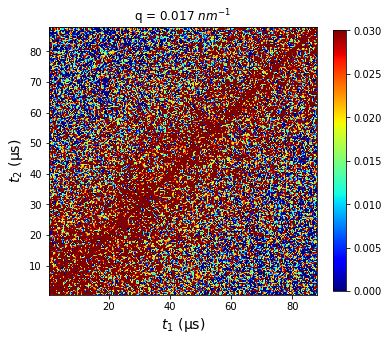

In [6]:
# input run numbers to average
run_nos = [287, 288, 289]
# run_nos = np.arange(276,280)

q_bin_no = 1
t_delay = 0.44 # micro second

for i,run in enumerate(run_nos):
    out_dir = f'{result_path}r{run:04d}'

    # load data
    qq = np.load(f'{out_dir}/qq.npy') # q point of XPCS analysis
    Qvals = np.array( [(qq[i+1]+qq[i]) / 2 for i in range(len(qq)-1)] )
    TTCF = xr.open_dataarray(f'{out_dir}/TTCF_corrected.nc')

    if i==0:
        TTC=TTCF.sel(qBin=q_bin_no)
    else:
        # append the TTCs
        TTC[:,:] += TTCF.sel(qBin=q_bin_no)[:,:]
        
# average the TTCs
Avg_TTC = TTC/(i+1)

# plot the averaged TTC
plt.figure(figsize=(6,6))
plt.imshow(Avg_TTC, vmin=0,vmax=0.03,cmap='jet',origin='lower', extent=[t_delay, np.size(TTC,0)*t_delay,t_delay, np.size(TTC,0)*t_delay])
plt.title(f'q = {Qvals[q_bin_no]:.3f} $nm^{{-1}}$')
plt.colorbar(shrink=0.8)
plt.xlabel('$t_1$ (μs)', fontsize=14)
plt.ylabel('$t_2$ (μs)', fontsize=14)

# Average g2 over runs

Text(0.5, 1.0, 'averaged runs: [287, 288, 289]')

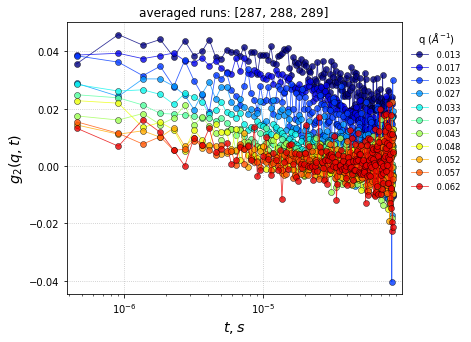

In [7]:
# input run numbers
# comment next line if you want to use the same run numbers as before
# run_nos = [186,187,188,189]

for i,run in enumerate(run_nos):
    out_dir = f'{result_path}r{run:04d}'
    
    # load data
    if i==0:
        CC = np.load(f'{out_dir}/cc.npy')
        qq = np.load(f'{out_dir}/qq.npy')
    else:
        CC[:,:] += np.load(f'{out_dir}/cc.npy')[:,:]
        
# average the g2s
Avg_CC = CC/(i+1)

# plot the g2s, see xpcs_analysis.py script
plot_xpcs(Avg_CC)
plt.title(f'averaged runs: {run_nos}')

**Fitting**

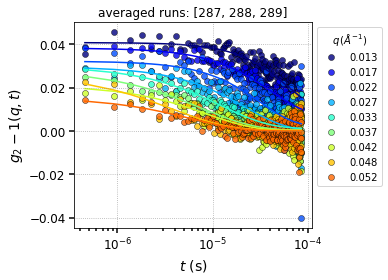

In [8]:
time = Avg_CC[:,0]
g2_values = Avg_CC[:,1:]
Qvals = np.array([(qq[i+1]+qq[i])/2 for i in range(len(qq)-1)])

g2 = 1

# plot
fig, ax = plt.subplots(figsize=(5.5,4))
colors = plt.cm.jet(np.linspace(0,1,len(Qvals)))

# arrays for storing fit parameters
betas, As, taus, kwws = np.zeros(len(Qvals)), np.zeros(len(Qvals)), np.zeros(len(Qvals)), np.zeros(len(Qvals)) # fit params
dbetas, dAs, dtaus, dkwws = np.zeros(len(Qvals)), np.zeros(len(Qvals)), np.zeros(len(Qvals)), np.zeros(len(Qvals)) # fit param errors

x = -1

for i in range(0, len(Qvals)-2):
    # fit correlation functions
    popt, pcov = curve_fit(exp_fun, # fit function defined above
                           time[1:-1], g2_values[1:-1,i], # y
                           p0=[0.03,0,7e-6,1], #initial parameters [contrast, A, tau, exponent]
                           bounds=([0.01,0,1e-6,0.5],[0.05,0.01,1e-4,2])) #parameter bounds [contrast, A, tau, exponent]
    # save fit params
    betas[i] ,As[i], taus[i], kwws[i] = popt
    perr = np.sqrt(np.diag(pcov)) # error of [contrast, A, tau, exponent] from covariance 
    dbetas[i], dAs[i], dtaus[i], dkwws[i] = perr
    
    # plot
    if g2 == 1:
        ax.errorbar(x=time[1:-1], y=g2_values[1:-1,i], fmt='o', ms=6, c=colors[i], 
                     mec='k', mew=.5, zorder=0, label=f'{Qvals[i]:.3f}', alpha=0.8) #, mfc='w'
        g2_fit = exp_fun(time[1:-1], *popt)
        ax.plot(time[1:-1], g2_fit, c=colors[i], zorder=1)

ax.set_xscale('log')
ax.set_ylabel(r'$g_{2}-1 (q,t)$', fontsize=14)
ax.set_xlabel(r'$t$ (s)', fontsize=14)
ax.legend(title='$q\,(\AA^{-1})$', frameon=True, bbox_to_anchor=[1.,1])
ax.grid(c='gray', ls=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(which='major', width=1.5, length=5)
ax.tick_params(which='minor', width=1.5, length=3)
ax.set_title(f'averaged runs: {run_nos}')
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

# plot fit parameters ###############

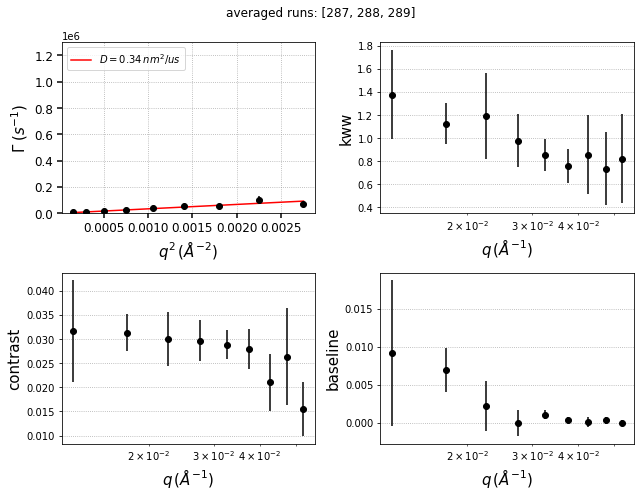

In [9]:
# set q-range for fitting
start, end = 0, -2

fig, ((a0,a1),(a2,a3)) = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(9,7))

# time constant
x = Qvals[start:end]**2 # Angs
y = 1/taus[start:end] # 1/s
a0.errorbar(x, y, yerr=dtaus[start:end]/taus[start:end]**2, fmt='o', c='k')
a0.set_ylim(0,1.3e6)
# fit of Gamma vs q^2
popt,pcov = curve_fit(linear, x, y, p0=[2e6,0.], bounds=([0,0.],[np.infty,1e-3]))
a0.plot(x, linear(x, *popt), c='r', label=f"$D={popt[0]*1e-8:.2f}\,nm^2/us$")    # here the diffusion coefficient is printed in the legend          
a0.set_xlabel(r'$q^2\,(Å^{-2})$',fontsize=15)
a0.set_ylabel(r'$\Gamma \;(s^{-1})$',fontsize=15)
a0.grid(c='gray', ls=':', alpha=0.7)
a0.tick_params(axis='both', which='major', labelsize=12,)
a0.tick_params(which='major', width=1.5, length=5)
a0.tick_params(which='minor', width=1.5, length=3)
a0.legend(loc='upper left')

# kww exponent
a1.errorbar(Qvals[start:end],kwws[start:end], yerr=dkwws[start:end], fmt='o', c='k')
a1.set_xlabel(r'$q\,(Å^{-1})$',fontsize=15)
a1.set_ylabel(r'kww',fontsize=15)
a1.grid(c='gray', ls=':', alpha=0.7)
a1.set_xscale('log')

# contrast
a2.errorbar(Qvals[start:end],betas[start:end],yerr=dbetas[start:end], fmt='o', c='k')
a2.set_xlabel(r'$q\,(Å^{-1})$',fontsize=15)
a2.set_ylabel(r'contrast',fontsize=15)
a2.grid(c='gray', ls=':', alpha=0.7)
a2.set_xscale('log')

# baseline
a3.errorbar(Qvals[start:end],As[start:end],yerr=dAs[start:end], fmt='o', c='k')
a3.set_xlabel(r'$q\,(Å^{-1})$',fontsize=15)
a3.set_ylabel(r'baseline',fontsize=15)
a3.grid(c='gray', ls=':', alpha=0.7)
a3.set_xscale('log')

plt.suptitle(f'averaged runs: {run_nos}')
plt.tight_layout()

# SAXS pulse resolved single run

In [10]:
# run number for saxs
run_no = 289

out_dir = f'{result_path}r{run_no:04d}'

# load data
SAXS = np.load(f'{out_dir}/SAXS.npy')
q = np.load(f'{out_dir}/q.npy') # q point of SAXS analysis

Text(0.5, 1.0, 'r0289')

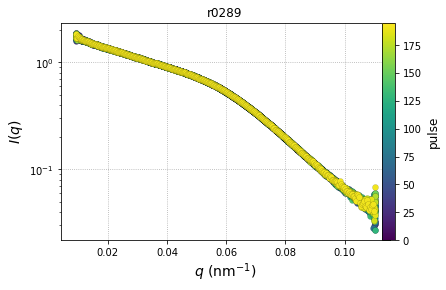

In [11]:
# q-bin for normalisation 
qrange = (q>0.03) & (q<0.04)

fig,ax = plt.subplots(figsize=(6,4))
col = plt.cm.viridis(np.linspace(0,1,200))

# number of pulses averaged
dt = 5
for i in range(0,200,dt):
    i_norm = np.mean((SAXS[i:i+dt,:]),0)
    ax.plot(q,i_norm/np.mean(i_norm[qrange]),c=col[i,:], ls='', marker='o', mec='black', mew=.1)
ax.set_yscale('log')
ax.set_ylabel('$I(q)$', fontsize=14)
ax.set_xlabel('$q$ (nm$^{-1}$)', fontsize=14)

ax.grid(ls=':', c='grey', alpha=0.7)
add_colorbar_hor(ax, np.arange(0,200,dt), label='pulse')
ax.set_title(f'r{run_no:04d}')

(0.8, 1.2)

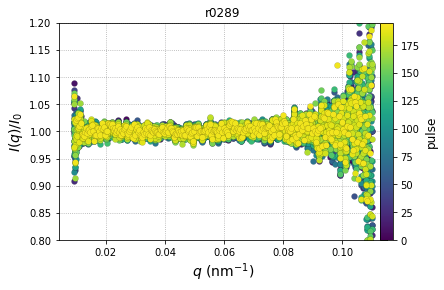

In [12]:
# number of pulses averaged
dt = 5

# intensity of the first pulse for normalisation
i_0 = np.mean((SAXS[:dt,:]), axis=0)
I_0 = i_0/np.mean(i_0[qrange])

fig,ax = plt.subplots(figsize=(6,4))
col = plt.cm.viridis(np.linspace(0,1,200))

for i in range(0,200,dt):
    i_norm = np.mean((SAXS[i:i+dt,:]),0)
    ax.plot(q, i_norm/np.mean(i_norm[qrange])/I_0, c=col[i,:], ls='', marker='o', mec='k', mew=.1)
ax.set_ylabel('$I(q)$/$I_0$', fontsize=14)
ax.set_xlabel('$q$ (nm$^{-1}$)', fontsize=14)

ax.grid(ls=':',color='grey',alpha=0.7)
add_colorbar_hor(ax, np.arange(0,200,dt), label='pulse')
ax.set_title(f'r{run_no:04d}')
ax.set_ylim(.8,1.2)

# Compare different runs

### Compare different wt%

Text(0.5, 1.0, 'Ferritin with crowders')

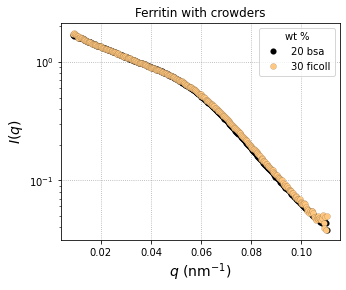

In [17]:
# run numbs to compare
# run_comparinson = [259,270,284,289]
run_comparinson = [259,289]
labels = ['20 bsa','30 ficoll'] # wt% in this case

# q-bin for normalisation 
qrange = (q>0.03) & (q<0.04)

fig,ax = plt.subplots(figsize=(5,4))
col = plt.cm.copper(np.linspace(0,1,len(run_comparinson)))

# number of pulses averaged
dt = 5

i=0
for c,run_no in enumerate(run_comparinson):
    out_dir = f'{result_path}r{run_no:04d}'

    # load data
    SAXS = np.load(f'{out_dir}/SAXS.npy')
    q = np.load(f'{out_dir}/q.npy') # q point of SAXS analysis

    i_norm = np.mean((SAXS[i:i+dt,:]),0)
    ax.plot(q,i_norm/np.mean(i_norm[qrange]),c=col[c,:], ls='', marker='o', mec='black', mew=.1)

ax.set_yscale('log')
ax.set_ylabel('$I(q)$', fontsize=14)
ax.set_xlabel('$q$ (nm$^{-1}$)', fontsize=14)
ax.legend(labels,title='wt %')

ax.grid(ls=':', c='grey', alpha=0.7)
ax.set_title(f'Ferritin with crowders')